## Initial Look

Libraries to be used in the file parsing.

In [1]:
import os.path # Used for isfile()

# For plotting
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib

import numpy as np # for arange
from collections import OrderedDict # For creation of a sorted dictionary

The following function is used to parse through the files that do not have any particular program that I am interested in.

In [2]:
def parseTop(oldfile, newfile, wordsToDelete):
    """
    This function takes in a top file run in batch mode and removes the headers
    The remaining file should only be process information
    """
    if not os.path.isfile(newfile):
        with open(oldfile) as f, open(newfile, "w") as nf:
            for line in f:
                if not any(line.startswith(no) for no in wordsToDelete):    # removes any line that starts with a word in wordsToDelete
                    if not line.isspace():                                  # removes any empty lines
                        nf.write(line.lstrip(' '))                          # The lstrip method is to remove the starting empty space
    else:
        print("File already exists, are you sure you want to do this?")

Then I want to have a version of the above function that returns a new file that only has the process I'm interested in.

In [3]:
def returnOne(oldfile, newfile, processName):
    """
    Takes in an oldfile location and a new file location
    old file location is a top batch file
    new file is the oldfile where only one process
    """
    if not os.path.isfile(newfile):
        with open(oldfile) as f, open(newfile, "w") as nf:
            for line in f:
                if processName in line:
                    nf.write(line)

    else:
        print("File already exists")

Then finally I want to read the new files that have been parsed and return a dictionary storing all the PIDs and the corresponding CPU usage and memory usage.

In [4]:
def readFile(file = "result.txt"):
    """
    This function takes in a file and returns lists of all processes as dictionaries
    The dictionaries have the structure of d = {'123': [1, 2, 3, 4, 5]}
    The key is Process ID number and always greater than 0 stored as string
    List contains floats
    """
    
    # PIDCPU will hold a key to a PID
    # number and output a list of CPU used
    # PIDMEM will do the very same
    # thing however with the MEM used

    PIDCPU = {}
    PIDMEM = {}
    if os.path.isfile(file):
        with open(file) as f:
            for line in f:
                if not line.startswith("PID"):
                    s = line.split()

                    # s[0] is the very first string in
                    # the line. This is always PID number

                    if s[0] not in PIDCPU or s[0] not in PIDMEM:
                        # s[8] is the %CPU number
                        PIDCPU[s[0]] = list()
                        PIDCPU[s[0]].append(float(s[8]))

                        # s[9] is the %MEM number
                        PIDMEM[s[0]] = list()
                        PIDMEM[s[0]].append(float(s[9]))
                    else:
                        PIDCPU[s[0]].append(float(s[8]))
                        PIDMEM[s[0]].append(float(s[9]))

            return PIDCPU, PIDMEM
    else:
        print("File does not exist")

The file locations are then put into variables along with some words to avoid

In [5]:
PI = "../Text/pi.txt"
PIRESULT = "../Results/Text/piResult.txt"

PIPROGRAM = "../Text/piProgram.txt"
PIPROGRESULT = "../Results/Text/piProgResult.txt"

avoid = ["top", "Tasks", "%Cpu(s)", "KiB Mem", "KiB Swap"]

Here I begin by parsing through the RPI files where no program was running.

Through some inspection of the files, I know that w1_bus_master (PID = 169) and docker (PID = 455, 499) seem to be the biggest CPU consumers.

File already exists, are you sure you want to do this?


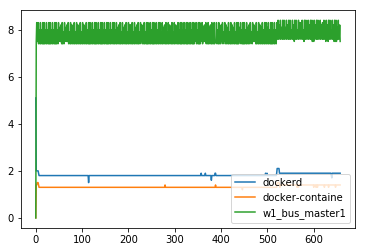

In [6]:
parseTop(PI, PIRESULT, avoid)
cpuPi, memPi = readFile(PIRESULT)

x = np.arange(0, len(cpuPi["455"]))

y1 = cpuPi["455"]
y2 = cpuPi["499"]
y3 = cpuPi["169"]

plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

plt.legend(["dockerd", "docker-containe", "w1_bus_master1"], loc = "lower right")
plt.show()

For memory, the most consuming tasks are a little different. Docker consumes quite a bit of memory (PID = 455, 499) however the bus doesn't.

Through inspection, the sshd (PID = 448), bash (PID = 532), systemd (PID = 1), mtpd (PID = 475), vncserver (PID = 451) all consume >1% of %MEM.

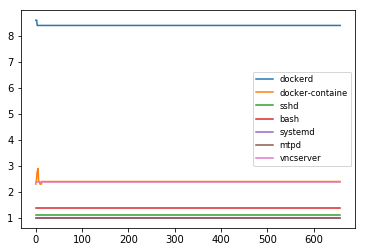

In [7]:
x = np.arange(0, len(memPi["455"]))

z1 = memPi["455"]
z2 = memPi["499"]
z3 = memPi["448"]
z4 = memPi["532"]
z5 = memPi["1"]
z6 = memPi["475"]
z7 = memPi["451"]

plt.plot(x, z1)
plt.plot(x, z2)
plt.plot(x, z3)
plt.plot(x, z4)
plt.plot(x, z5)
plt.plot(x, z6)
plt.plot(x, z7)

fontP = FontProperties()
fontP.set_size('small')

plt.legend(["dockerd", "docker-containe", "sshd", "bash", "systemd", "mtpd", "vncserver"],
          prop = fontP)
plt.show()

Now, it's time to see how much CPU/MEM the audio and fft take.

First, create the two dictionaries I will be graphing with

In [8]:
returnOne(PIPROGRAM, PIPROGRESULT, "main")
cpu, mem = readFile(PIPROGRESULT)

File already exists


Then the creation of a simple line graph.

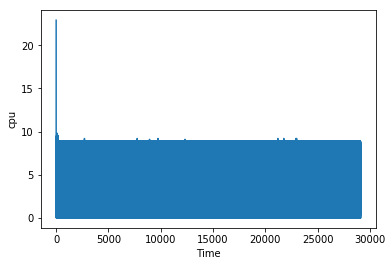

In [9]:
l = np.arange(0, len(cpu['21540']))
y = cpu['21540']

plt.plot(l, y)
plt.xlabel("Time")
plt.ylabel("cpu")
plt.show()

Unfortunately, when I was taking the results, I forgot to put in a reasonable delay. So, here I just graph only 100 results.

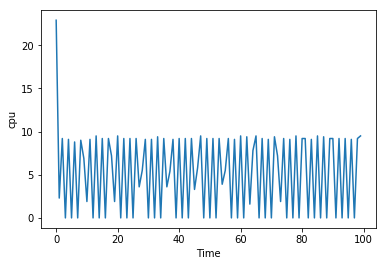

In [10]:
l1 = np.arange(0, len(cpu['21540'][0:100]))
f1 = cpu['21540'][0:100]

plt.plot(l1, f1)
plt.xlabel("Time")
plt.ylabel("cpu")
plt.show()

Now in terms of memory.

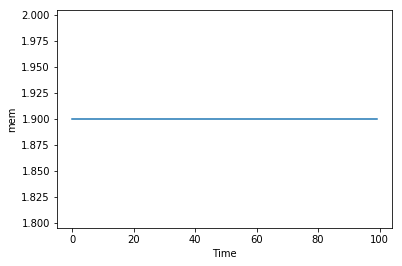

In [11]:
mx1 = np.arange(0, len(mem['21540'][0:100]))
my1 = mem['21540'][0:100]

plt.plot(mx1, my1)
plt.xlabel("Time")
plt.ylabel("mem")
plt.show()

## Deeper Look

Time to look a little closer at what is actually happening in the idle Raspberry Pi case

From doing a more through inspection of the initial data, we can see that the there is something I missed initially.

Process 12328 consumes 11% of the cpu power on average. After that, only the 3 processes I mentioned consume any kind of real processor power. The rest is all sub 0.1% cpu. At a later stage, I will probably combine everyone of these cpu processes together.

In [12]:
average = {}

for k in cpuPi:
    mean = np.mean(cpuPi[k])
    average[k] = mean
    
sortedCPU = OrderedDict(sorted(average.items(), reverse = True, key = lambda t: t[1]))

for k in sortedCPU:
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

Key: 12328	Mean 11.25
Key: 169	Mean 7.76823708207
Key: 455	Mean 1.82887537994
Key: 499	Mean 1.31975683891
Key: 553	Mean 0.1
Key: 118	Mean 0.0998480243161
Key: 451	Mean 0.0998480243161
Key: 9259	Mean 0.090625
Key: 11974	Mean 0.0894736842105
Key: 10938	Mean 0.0888888888889
Key: 336	Mean 0.0888888888889
Key: 2593	Mean 0.0875
Key: 7968	Mean 0.0875
Key: 31936	Mean 0.0866666666667
Key: 1016	Mean 0.0866666666667
Key: 3612	Mean 0.0866666666667
Key: 6335	Mean 0.0864864864865
Key: 10102	Mean 0.0846153846154
Key: 1652	Mean 0.0833333333333
Key: 3304	Mean 0.0833333333333
Key: 5093	Mean 0.0833333333333
Key: 628	Mean 0.0833333333333
Key: 2295	Mean 0.0833333333333
Key: 2090	Mean 0.0818181818182
Key: 7733	Mean 0.0818181818182
Key: 10557	Mean 0.08125
Key: 32431	Mean 0.08125
Key: 3905	Mean 0.08
Key: 4217	Mean 0.08
Key: 5375	Mean 0.0791666666667
Key: 1176	Mean 0.0785714285714
Key: 3579	Mean 0.0785714285714
Key: 7514	Mean 0.0777777777778
Key: 30313	Mean 0.0777777777778
Key: 30514	Mean 0.0777777777778
Key: 

In [13]:
keys = ['12328', '169', '455', '499']
concise = {}
t = []

from itertools import zip_longest

for k in cpuPi:
    if k in keys:
        concise[k] = cpuPi[k]
    else: # At this point, I want to add everything into an 'everything else' list
        t = [x + y for x, y in zip_longest(t, cpuPi[k], fillvalue = 0)]
        
concise['all'] = t

concise['12328'].extend([0] * (len(concise['all']) - len(concise['12328'])))

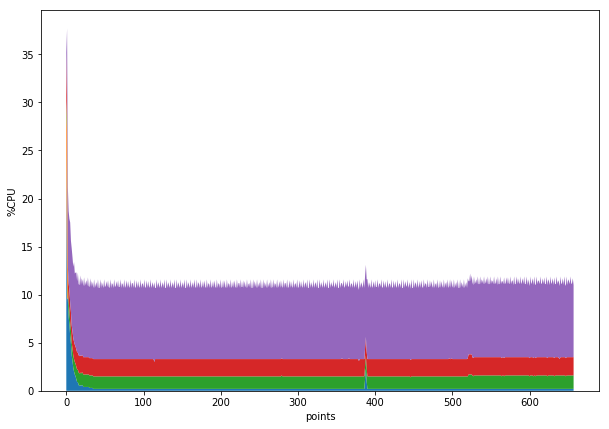

In [14]:
points = np.arange(0, len(concise['all']))

plt.figure(figsize=(10,7))
plt.stackplot(points, concise['all'], concise['12328'], concise['499'], concise['455'], concise['169'])
plt.ylabel('%CPU')
plt.xlabel('points')
plt.show()